In [99]:
### Hash Encoding NeRF based off of NVIDIA's hash nerf

In [1]:
import os
import torch
import torchvision
from torch import nn
from torchvision import transforms
from torch.utils.data import Dataset
import imageio.v3 as iio
import numpy as np
import matplotlib.pyplot as plt
import time
from pthflops import count_ops
from tqdm import tqdm
import math

print(torch.__version__)

torch.manual_seed(42)

2.0.1+cu118


In [3]:
#Load video file
vRead = iio.imread('data/c_elegans.mp4')
video = np.array(vRead)
video = torch.as_tensor(video)
testFrame = video[0]


2484 torch.Size([270, 344, 3])
Error in callback <function _draw_all_if_interactive at 0x7faff1bc9af0> (for post_execute):


KeyboardInterrupt: 

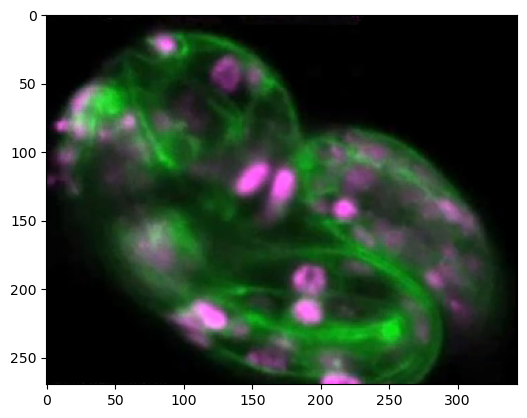

In [102]:

plt.imshow(video[100][18:288])
print(len(video), video[200][18:288].shape)

tensor([[[[0.0235, 0.0235, 0.0235],
          [0.0392, 0.0392, 0.0392],
          [0.0471, 0.0471, 0.0471],
          ...,
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000],
          [0.0078, 0.0078, 0.0078],
          [0.0157, 0.0157, 0.0157],
          ...,
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0078, 0.0078, 0.0078],
          ...,
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000]],

         ...,

         [[0.0039, 0.0039, 0.0039],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          ...,
          [0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039]],

         [[0.0000, 0.0000, 0.0000],
          [0.0000

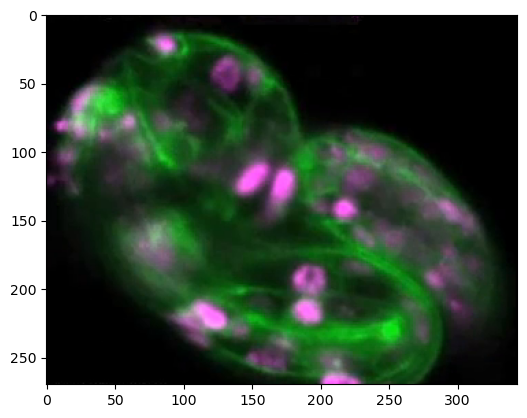

In [4]:

### Crop letters from video
def writeVideoMOV(videoTensor, filename='decoded'):

    w = iio.get_writer(filename + '.mov', format='FFMPEG', mode='I', fps=20,
                        codec='h264_vaapi',
                        output_params=['-vaapi_device',
                                        '/dev/dri/renderD128',
                                        '-vf',
                                        'format=gray|nv12,hwupload'],
                        pixelformat='vaapi_vld')
    for frame in videoTensor:
        w.append_data(frame.numpy())
    w.close()
    print('video saved in local directory as: ' + filename + '.mov')
    return None

croppedVideo = torch.zeros((2484, 270, 344,3)).type(torch.float32)
for i in range(len(video)):
    croppedVideo[i] = video[i][18:288]

croppedVideo = torch.mul(croppedVideo, 1/255.0).type(torch.float32)
plt.imshow(croppedVideo[100])
#writeVideoMOV(croppedVideo, filename="cropped_C_Elegans")
#Set Video to cropped version
video = croppedVideo
print(video)


In [ ]:
video.shape

torch.Size([2484, 270, 344, 3])

In [5]:
print("Cuda available: ", torch.cuda.is_available())
if(torch.cuda.is_available()):
    torch.cuda.set_device("cuda:1")

    print("Is cuDNN version:", torch.backends.cudnn.version())

    print("cuDNN enabled:a", torch.backends.cudnn.enabled)

    print("Device count: ", torch.cuda.device_count())

    print("Current device: ", torch.cuda.current_device())

    print("Device name: ", torch.cuda.get_device_name(torch.cuda.current_device()))
#Setup device agnostic code (i.e use GPU if possible)
device = "cuda" if torch.cuda.is_available() else "cpu"
gpuNum = 1
print(device)
video = video.to(device)

Cuda available:  True
Is cuDNN version: 8700
cuDNN enabled:a True
Device count:  3
Current device:  1
Device name:  NVIDIA TITAN Xp
cuda


In [6]:
#Video Metadata
import imageio.v3 as iio
props = iio.improps("data/c_elegans.mp4")
print("Shape (frames, w, h, RGB): \n" + str(props.shape))
numFrames = props.shape[0]
print(props.dtype)

Shape (frames, w, h, RGB): 
(inf, 322, 344, 3)
uint8


In [1]:
np.random.seed(seed=42)
class hashNeRF(nn.Module):
    def __init__(self,
                input_shape: int,
                hidden_units: int,
                output_shape: int):
        super().__init__()
        self.L = 16
        self.T = 2**18
        self.F = 16
        self.N_min = 16
        self.N_max = 512
        self.num_output = 1
        b = np.exp((np.log(self.N_max) - np.log(self.N_min)) / (self.L - 1))
        self.N_values = torch.tensor(np.float32(self.N_min * b ** np.arange(self.L))).cpu() # multi-resolution N-values between range
        temp_hash_table = torch.tensor(np.random.uniform(low=-1e-4, high=1e-4, size=(self.L,self.T,self.F))).type(torch.float32).to(device)
        self.hash_table = nn.Parameter(torch.tensor(temp_hash_table.clone().detach().requires_grad_(True), requires_grad=True))
        self.vertices = torch.tensor(np.array([[0, 0, 0, 0],
                                              [0, 0, 0, 1],
                                              [0, 0, 1, 0],
                                              [0, 0, 1, 1],
                                              [0, 1, 0, 0],
                                              [0, 1, 0, 1],
                                              [0, 1, 1, 0],
                                              [0, 1, 1, 1],
                                              [1, 0, 0, 0],
                                              [1, 0, 0, 1],
                                              [1, 0, 1, 0],
                                              [1, 0, 1, 1],
                                              [1, 1, 0, 0],
                                              [1, 1, 0, 1],
                                              [1, 1, 1, 0],
                                              [1, 1, 1, 1],
                                              ], dtype=np.float32).T).cpu()
        self.prime_numbers = torch.tensor([1, 2654435761, 805459861, 19349663]).type(torch.int32).cpu()
        self.layer_stack = nn.Sequential(
            nn.Linear(input_shape, hidden_units),
            nn.LeakyReLU(),
            nn.Linear(hidden_units, hidden_units), 
            nn.LeakyReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.LeakyReLU(),
            nn.Linear(hidden_units, output_shape),
            nn.Sigmoid()
        )
        
    def forward(self, X):
        # x is a 4D coordinate of shape (num_points, 4); in the range of [0,1], roughly
        # multi-resolution hash encoding:
        x = X.cpu()
        #print(x.shape)
        #print(self.N_values.shape)
        x_scaled = x[:, :, None] * self.N_values[None, None, :]  # shape: num_points, 4, L
        x_floored = torch.floor(x_scaled).cpu()

        # 16 vertices in xyzt space:
        x_vertices = x_floored[:, :, :, None] + self.vertices[None, :, None, :]  # shape: num_points, 4, L, 16

        x_vertices = x_vertices.type(torch.int64).cpu()
        x_to_hash = x_vertices * self.prime_numbers[None, :, None, None]
        x_hash = torch.bitwise_xor(
            torch.bitwise_xor(
                torch.bitwise_xor(x_to_hash[:, 0],
                                       x_to_hash[:, 1]),
                x_to_hash[:, 2]),
            x_to_hash[:, 3])  # shape: num_points, L, 16
        #print("x_hash shape:", x_hash.shape)
        x_hash = torch.remainder(x_hash, self.T)  # these are now indices
        #print(x_hash)
        #print("x_hash shape:", x_hash.shape)
        # transpose for map_fn:
        #SWAP HERE -v
        #x_hash = np.transpose(x_hash.cpu().numpy(), [1,0,2]) #implies dim 2 is last?
        #print('x_hash shape:', x_hash.shape)
        x_h_temp = np.transpose(x_hash.cpu().numpy(), [1,0,2])
        #x_hash = torch.transpose(x_hash, 0,1)
        x_hash = torch.tensor(x_h_temp).type(torch.int64)
        #print('x_hash shape:', x_hash.shape)

        #print("x_hash shape:", x_hash.shape)
        # lookup hash table:
        gather = lambda a: torch.gather(a[0], 0, a[1])
        #print("x_hash shape:", x_hash.shape)
        #print("hash table shape:", self.hash_table.shape)
        #
        #tempNPArr = torch.transpose(self.hash_table, 1,0).cpu()
        #tempNPArrHash = torch.transpose(x_hash, 0,1)# already moved to CPU and np nd ar format for tranpose operation
        tempNPArr = self.hash_table
        tempNPArrHash = x_hash
        #print('tempNPARR',tempNPArr.shape)
        #print('tempNPArrHash',tempNPArrHash.shape)
        #fn = np.vectorize(gather)
        #lookup1 = fn(tempNPArr)
        #lookup2 = fn(tempNPArrHash)
        #input_lookup = torch.as_tensor([tempNPArr, tempNPArrHash])
        print(tempNPArr.shape)
        print(tempNPArrHash.shape)
        lookup = gather((torch.as_tensor(tempNPArr).cpu(), torch.as_tensor(tempNPArrHash).cpu()))
        #print(lookup.shape)
        #print("oops")
        #print('old lookup shape:', lookup.shape)
        lookup = torch.tensor(lookup).cpu().numpy()
        #lookup = torch.transpose(lookup, 0, 1)  # shape: num_points, L, 16, F
        print(lookup.shape)
        lookup_temp = np.transpose(lookup, [1,0,2])
        lookup = torch.tensor(lookup_temp).type(torch.float32)
        print(lookup.shape)
        #print(lookup.shape)

        weights = x_scaled - x_floored
        fx = weights[:, 0, :]
        cx = 1 - fx
        fy = weights[:, 1, :]
        cy = 1 - fy
        fz = weights[:, 2, :]
        cz = 1 - fz
        ft = weights[:, 3, :]
        ct = 1 - ft

        f1111 = fx * fy * fz * ft
        f1110 = fx * fy * fz * ct
        f1101 = fx * fy * cz * ft
        f1100 = fx * fy * cz * ct
        f1011 = fx * cy * fz * ft
        f1010 = fx * cy * fz * ct
        f1001 = fx * cy * cz * ft
        f1000 = fx * cy * cz * ct
        f0111 = cx * fy * fz * ft
        f0110 = cx * fy * fz * ct
        f0101 = cx * fy * cz * ft
        f0100 = cx * fy * cz * ct
        f0011 = cx * cy * fz * ft
        f0010 = cx * cy * fz * ct
        f0001 = cx * cy * cz * ft
        f0000 = cx * cy * cz * ct  # shape: num_points, L
        f_stack = torch.stack([f0000, f0001, f0010, f0011, f0100, f0101, f0110, f0111,
                            f1000, f1001, f1010, f1011, f1100, f1101, f1110, f1111], dim=2)  # shape: num_points, L, 16
        """
        print(f_stack.shape, lookup.shape)
        print("input shapes: ", f_stack[:, :, :, None].shape, lookup.shape)
        print("try squeezing last dim: ", torch.squeeze(f_stack[:, :, :, None], dim=3).shape)
        """
        print(f_stack.shape)
        x_interp = torch.sum(f_stack[:, :, :, None] * lookup, dim=2)  # shape: num_points, L, F
        print(x_interp.shape)
        #x = x_interp
        x = torch.reshape(x_interp, (-1, self.L * self.F))
        print(x.shape)
        return self.layer_stack(x.to(device).type(torch.float32))

NameError: name 'np' is not defined

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class MultiresHashNerf(nn.Module):
    def __init__(self, hidden_layer_list, L=16, T=2**18, F=2, N_min=16, N_max=512, output_nonlinearity='relu',
                 num_output=1,
                 seed=0, MLP_L2_reg=None):
        super(MultiresHashNerf, self).__init__()
        self.hidden_layer_list = hidden_layer_list
        self.L = L
        self.T = T
        self.F = F
        self.N_min = N_min
        self.N_max = N_max
        self.output_nonlinearity = output_nonlinearity
        self.num_output = num_output
        self.MLP_L2_reg = MLP_L2_reg

        if MLP_L2_reg is not None:
            self.kernel_regularizer = nn.L2Loss(self.MLP_L2_reg)
        else:
            self.kernel_regularizer = None

        b = np.exp((np.log(N_max) - np.log(N_min)) / (L - 1))
        self.N_values = torch.FloatTensor(N_min * b ** np.arange(L)).to(torch.device('cuda'))  # multi-resolution
        self.hash_table = nn.Parameter(torch.FloatTensor(L, T, F).uniform_(-1e-4, 1e-4).to(torch.device('cuda')))

        self.vertices = torch.FloatTensor([
            [0, 0, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0], [0, 0, 1, 1],
            [0, 1, 0, 0], [0, 1, 0, 1], [0, 1, 1, 0], [0, 1, 1, 1],
            [1, 0, 0, 0], [1, 0, 0, 1], [1, 0, 1, 0], [1, 0, 1, 1],
            [1, 1, 0, 0], [1, 1, 0, 1], [1, 1, 1, 0], [1, 1, 1, 1]
        ]).to(torch.device('cuda'))  # shape: 4, 16
        self.prime_numbers = torch.LongTensor([1, 2654435761, 805459861, 19349663]).to(torch.device('cuda'))
        self._build_mlp()

    def _build_mlp(self):
        self.layers_list = nn.ModuleList()
        for num_units in self.hidden_layer_list:
            self.layers_list.append(nn.Linear(num_units, num_units))
            self.layers_list.append(nn.LeakyReLU())

        self.layers_list.append(nn.Linear(self.hidden_layer_list[-1], self.num_output))  # output fluorescence

        if self.output_nonlinearity == 'leaky_relu':
            self.layers_list.append(nn.LeakyReLU())
        elif self.output_nonlinearity == 'relu':
            self.layers_list.append(nn.ReLU())
        elif self.output_nonlinearity == 'linear':
            pass
        else:
            raise Exception('Invalid nonlinearity')

    def forward(self, x):
        # x is a 4D coordinate of shape (num_points, 4); in the range of [0,1], roughly
        # multi-resolution hash encoding:
        x = x.to(torch.device('cuda'))
        x_scaled = x[:, :, None] * self.N_values[None, None, :].to(torch.device('cuda'))  # shape: num_points, 4, L
        x_floored = torch.floor(x_scaled).to(torch.device('cuda'))

        # 16 vertices in xyzt space:
        x_vertices = x_floored[:, :, :, None].to(torch.device('cuda')) + self.vertices[None, :, None, :].to(torch.device('cuda'))  # shape: num_points, 4, L, 16

        x_vertices = x_vertices.type(torch.int64).to(torch.device('cuda'))
        x_to_hash = x_vertices * self.prime_numbers[None, :, None, None]
        x_hash = torch.bitwise_xor(
            torch.bitwise_xor(
                torch.bitwise_xor(x_to_hash[:, 0],
                                  x_to_hash[:, 1]),
                x_to_hash[:, 2]),
            x_to_hash[:, 3])  # shape: num_points, L, 16
        x_hash = torch.fmod(x_hash, self.T)  # these are now indices
        # transpose for map_fn:
        x_hash = x_hash.permute(1, 0, 2)  # shape: L, num_points, 16
        # lookup hash table:
        def gather(a):
            return torch.gather(a[0], 1, a[1].unsqueeze(2).expand(-1, -1, self.F))
        lookup = torch.stack([gather((self.hash_table, x_hash[i])) for i in range(self.L)], dim=1)
        lookup = lookup.permute(0,1,2,3)  # shape: num_points, L, 16, F

        weights = x_scaled - x_floored
        
        fx = weights[:, 0, :]
        cx = 1 - fx
        fy = weights[:, 1, :]
        cy = 1 - fy
        fz = weights[:, 2, :]
        cz = 1 - fz
        ft = weights[:, 3, :]
        ct = 1 - ft

        f1111 = fx * fy * fz * ft
        f1110 = fx * fy * fz * ct
        f1101 = fx * fy * cz * ft
        f1100 = fx * fy * cz * ct
        f1011 = fx * cy * fz * ft
        f1010 = fx * cy * fz * ct
        f1001 = fx * cy * cz * ft
        f1000 = fx * cy * cz * ct
        f0111 = cx * fy * fz * ft
        f0110 = cx * fy * fz * ct
        f0101 = cx * fy * cz * ft
        f0100 = cx * fy * cz * ct
        f0011 = cx * cy * fz * ft
        f0010 = cx * cy * fz * ct
        f0001 = cx * cy * cz * ft
        f0000 = cx * cy * cz * ct  # shape: num_points, L
        f_stack = torch.stack([f0000, f0001, f0010, f0011, f0100, f0101, f0110, f0111,
                               f1000, f1001, f1010, f1011, f1100, f1101, f1110, f1111], dim=2)  # shape: num_points, L, 16

        x_interp = torch.sum(f_stack[:, :, :, None] * lookup, dim=2)  # shape: num_points, L, F
        x = x_interp.view(-1, self.L * self.F)

        # MLPs:
        for layer in self.layers_list:
            x = layer(x)

        return x



In [ ]:
model_0.hash_table.shape

NameError: name 'model_0' is not defined

In [ ]:
dummy = torch.zeros([16,256,17]).cpu()
print(dummy.shape)
dummy = torch.transpose(dummy, 0,1)
print(dummy.shape)

torch.Size([16, 256, 17])
torch.Size([256, 16, 17])


In [11]:
import os
from torch.utils.data import DataLoader
currFrame = 0
class SingleImageDataset(Dataset):
    def __init__(self, image, transform=None, target_transform=None):
        self.image = image.type(torch.float32)
        self.transform = transform
        self.target_transform = target_transform
    def __len__(self):
        return int(self.image.shape[0]) * int(self.image.shape[1])
    def __getitem__(self, idx):
        row = idx // int(self.image.shape[1])
        col = idx % int(self.image.shape[1])
        pixel = torch.as_tensor(self.image[row][col]).type(torch.float32).to(device)
        #label = pixel
        return torch.as_tensor([row, col, 0, 0]).to(device), pixel
workingFrame = video[currFrame]
training_data = SingleImageDataset(workingFrame)

In [ ]:
#### Dataloader which send in entire image
"""
import os
from torch.utils.data import DataLoader
currFrame = 0
class SingleImageDataset(Dataset):
    def __init__(self, image, transform=None, target_transform=None):
        self.image = image.type(torch.float32)
        self.transform = transform
        self.target_transform = target_transform
    def __len__(self):
        return int(self.image.shape[0]) * int(self.image.shape[1])
    def __getitem__(self, idx):
        row = idx // int(self.image.shape[1])
        col = idx % int(self.image.shape[1])
        pixel = torch.as_tensor(self.image[row][col]).type(torch.float32).to(device)
        #label = pixel
        return video[0], video[0]
workingFrame = video[currFrame]
training_data = SingleImageDataset(workingFrame)
"""

: 

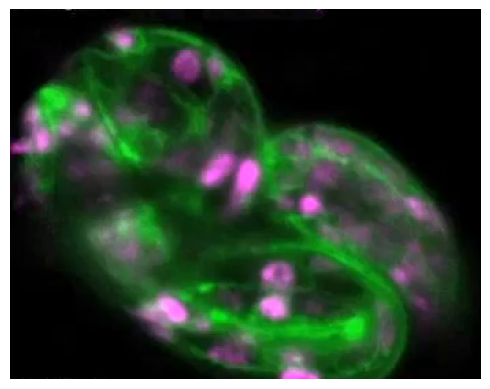

In [ ]:
#DataLoader Sanity Check!
testGrid = torch.empty(video[currFrame].shape[0], video[currFrame].shape[1], 3).cpu()
testGrid = testGrid.type(torch.float64)
train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True)
for batch in iter(train_dataloader):
    coords = batch[0]
    pixels = batch[1]
    for i in range(0, len(coords)):
        row = coords[i][0]
        col = coords[i][1]
        pixel = pixels[i]
        testGrid[row][col] = pixel
#testGrid = torch.mul(testGrid, 1)
plt.imshow(testGrid.cpu());
plt.axis(False);

In [29]:
##Utils
import math
def PSNR(MSELoss, max):
    return (20*math.log10(max)) - (10*math.log10(MSELoss))

In [30]:
from pathlib import Path
def saveModel(modelPointer, psnr_note=35, frameNumber=0):
    # 1. Create models directory - won't create if it exists
    MODEL_PATH = Path("models")
    MODEL_PATH.mkdir(parents=True, exist_ok=True)
    # 2. Create model save path
    MODEL_NAME = "hashNerf_psnr_frame_"+frameNumber+"_psnr_"+str(psnr_note)+".pth"
    MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
    MODEL_SAVE_PATH
    #3. Save the model state dict
    print(f"Saving model to: {MODEL_SAVE_PATH}")
    torch.save(obj=modelPointer.state_dict(),
            f=MODEL_SAVE_PATH)
    print(MODEL_SAVE_PATH)

In [36]:
#initialize model
model_0 = MultiresHashNerf([256,256,256,256]).to(device)

In [37]:
lr1 = 0.001
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=lr1, eps=10e-15)

In [1]:
# Training
from tqdm import tqdm
train_loader = DataLoader(training_data, batch_size=2**16, shuffle=True, pin_memory=False)
batchCount = 0
psnr_table = []
savedAt25 = False
savedAt30 = False
for epoch in tqdm(range(0,50)):
    #Training
    model_0.train()
    if savedAt30 == True:
        break
    for batch in iter(train_loader):
        batchCount += 1
        encodings = torch.as_tensor(batch[0]).to(device)
        print("shape of encodings:", encodings.shape)
        y_train = torch.as_tensor(batch[1]).to(device)
        y_train = torch.squeeze(y_train)
        print(y_train.shape)
        X = torch.as_tensor(encodings).type(torch.float64).to(device)
        y_train = torch.as_tensor(y_train).type(torch.float64).to(device)
        # Forward Pass
        y_pred = model_0(X.cpu()).to(device).type(torch.float64)
        loss = loss_fn(y_pred, y_train)
        psnr = PSNR(loss, 1.0)
        psnr_table.append(psnr)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (savedAt25 == False) and (psnr >= 25):
        saveModel(model_0, 25, 0)
        savedAt25 = True
    elif (savedAt30 == False) and (psnr >= 30):
        saveModel(model_0, 30, 0)
        savedAt30 = True
        break
    if epoch % 1 == 0:
        print(f"Epoch: {epoch} | LR: {lr1} | Train loss: {loss} | PSNR: {psnr}")
    if epoch == 10:
        lr1 = lr1/10
    if epoch == 20:
        lr1 = lr1/2
print('Training Finished')

NameError: name 'DataLoader' is not defined

In [ ]:
#debug
#use working frame from data loader
frame_shape = workingFrame.shape
test_grid = torch.zeros([frame_shape[0], frame_shape[1], 4])
for i in range(0, frame_shape[0]):
        for j in range(0, frame_shape[1]):
            x = i * 1.0
            y = j * 1.0
            test_grid[i][j][0] = x 
            test_grid[i][j][1] = y
with torch.inference_mode():
    #test_grid = torch.tensor(test_grid)
    reconstruction = model_0(test_grid).cpu()
    print(reconstruction.shape)
    plt.imshow(reconstruction.reshape((frame_shape[0], frame_shape[1], 3)))
    plt.axis(False)
    plt.title("output after 30 epochs - Hash NeRF")


: 

In [ ]:
testGrid = torch.zeros(video[currFrame].shape[0], video[currFrame].shape[1], 3).cpu()
testGrid = testGrid.type(torch.float64)
train_dataloader = DataLoader(training_data, batch_size=256, shuffle=True)
for batch in iter(train_dataloader):
    coords = batch[0]
    pixels = batch[1]
    for i in range(0, len(coords)):
        row = coords[i][0]
        col = coords[i][1]
        #pixel = pixels[i]
        testGrid[row][col] = model_0(torch.as_tensor([[row, col, 0, 0]]))
#testGrid = torch.mul(testGrid, 1)
plt.imshow(testGrid.cpu());
plt.axis(False);

: 

In [ ]:
model_0.eval()
with torch.inference_mode():
    reconstruction = torch.zeros([frame_shape[0], frame_shape[1], 3])
    for i in range(0, frame_shape[0]):
        for j in range(0, frame_shape[1]):
            reconstruction[i][j] = model_0(torch.as_tensor([[i, j,0,0]])).cpu()
    plt.imshow(reconstruction)
    plt.axis(False)
    plt.title("output after 30 epochs - Hash NeRF")

: 

In [ ]:
#Plot PSNR
plt.plot(range(1,batchCount), psnr_table)
plt.title('Train error')
plt.ylabel('PSNR')
#NOT EPOCHS - THESE ARE BATCHES!!!
plt.xlabel('Batch Iter')
plt.legend()

plt.show()

: 

In [ ]:
# Check model size by summing parameters and state_dict
params_size = 0
for param in model_0.parameters():
    params_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model_0.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (params_size + buffer_size) / 1024**2
imageSize = 8 * image.shape[0] * image.shape[1] * image.shape[2]
imageSizeMB = imageSize / (10**6)
perDecrease = (imageSizeMB - size_all_mb) / imageSizeMB
perDecrease *= 100
print('original image size(no compression): {:.3f}MB'.format(imageSizeMB))
print('model size: {:.3f}MB'.format(size_all_mb))
print('Percent decrease in memory size: {:.3f}%'.format(perDecrease))

: 

In [ ]:
#DataLoader Sanity Check!
testGrid = torch.empty(video[currFrame].shape[0], video[currFrame].shape[1], 3).cpu()
testGrid = testGrid.type(torch.float64)
train_dataloader = DataLoader(training_data, batch_size=128, shuffle=True)
for batch in iter(train_dataloader):
    coords = batch[0]
    pixels = batch[1]
    for i in range(0, len(coords)):
        row = coords[i][0]
        col = coords[i][1]
        pixel = pixels[i]
        testGrid[row][col] = model_0(torch.tensor([[row, col, 0,0]])).cpu()
testGrid = torch.mul(testGrid, 1)
plt.imshow(testGrid.cpu());
plt.axis(False);

: 

In [ ]:
quit()

: 

: 